# Training Compiled Models

This notebook contains Oliver's in-development code for *training* a compiled model; might we observe the unlearning phenomenon? (This notebook is adapted from `examples/Visualize_Tracr_Models.ipynb`.)

In [1]:
#@title Imports
import jax
import numpy as np
import matplotlib.pyplot as plt
jax.config.update('jax_default_matmul_precision', 'float32') # The default of float16 can lead to discrepancies between outputs of the compiled model and the RASP program.
from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp
import jax.numpy as jnp             # Oliver added
import optax                        # Oliver added
import haiku as hk                  # Oliver added
import copy                         # Oliver added
import random                       # Oliver added
random.seed(314159+1)               # Oliver added
np.random.seed(3141592 + 1)         # Oliver added

ImportError: cannot import name 'compiling' from 'tracr.compiler' (unknown location)

In [ ]:
#@title Define RASP programs
def get_program(program_name, max_seq_len):
  """Returns RASP program and corresponding token vocabulary."""
  if program_name == "length":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_length()
  elif program_name == "frac_prevs":
    vocab = {"a", "b", "c", "x"}
    program = lib.make_frac_prevs((rasp.tokens == "x").named("is_x"))
  elif program_name == "dyck-2":
    vocab = {"(", ")", "{", "}"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}"])
  elif program_name == "dyck-3":
    vocab = {"(", ")", "{", "}", "[", "]"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}", "[]"])
  elif program_name == "sort":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort(
        rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
  elif program_name == "sort_unique":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort_unique(rasp.tokens, rasp.tokens)
  elif program_name == "hist":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_hist()
  elif program_name == "sort_freq":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_sort_freq(max_seq_len=max_seq_len)
  elif program_name == "pair_balance":
    vocab = {"(", ")"}
    program = lib.make_pair_balance(
        sop=rasp.tokens, open_token="(", close_token=")")
  else:
    raise NotImplementedError(f"Program {program_name} not implemented.")
  return program, vocab

In [ ]:
#@title: Assemble model
program_name = "sort"  #@param ["length", "frac_prevs", "dyck-2", "dyck-3", "sort", "sort_unique", "hist", "sort_freq", "pair_balance"]
SORT_MAX = 5  #@param {label: "Test", type: "integer"} # largest number in the vocab

program, vocab = get_program(program_name=program_name,
                             max_seq_len=SORT_MAX)

print(f"   Program: {program_name}")
print(f"   Input vocabulary: {vocab}")
print(f"   Context size: {SORT_MAX}")

assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=SORT_MAX,
      causal=False,# aha
      compiler_bos="bos",
      compiler_pad="pad",
      mlp_exactness=100)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


   Program: sort
   Input vocabulary: {1, 2, 3, 4, 5}
   Context size: 5


In [ ]:
# GENERATE A DATASET FOR TRAINING THE COMPILED MODEL
instance_lengths = 4
dataset_size = 10000 # 10**4
train_x = [["bos"]+random.choices(range(1,SORT_MAX+1),k=instance_lengths) for i in range(dataset_size)]
train_y = [["bos"]+sorted(x[1:]) for x in train_x]
dataset_size = 100 # 10**4
val_x = [["bos"]+random.choices(range(1,SORT_MAX+1),k=instance_lengths) for i in range(dataset_size)]
val_y = [["bos"]+sorted(x[1:]) for x in val_x]
dataset_size = 100 # 10**4
test_x = [["bos"]+random.choices(range(1,SORT_MAX+1),k=instance_lengths) for i in range(dataset_size)]
test_y = [["bos"]+sorted(x[1:]) for x in test_x]
# Confirm that the compiled model correctly solves the first few dataset instances
for i in range(3):
    print(train_x[i], train_y[i], assembled_model.apply(train_x[i]).decoded)

['bos', 1, 2, 5, 2] ['bos', 1, 2, 2, 5] ['bos', 1, 2, 2, 5]
['bos', 4, 4, 4, 3] ['bos', 3, 4, 4, 4] ['bos', 3, 4, 4, 4]
['bos', 3, 5, 5, 1] ['bos', 1, 3, 5, 5] ['bos', 1, 3, 5, 5]


In [ ]:
# PERTURB THE PARAMETERS
perturb_parameters = True
if perturb_parameters:
    x = ["bos", 1,3,2,1]
    print('BEFORE PERTURBATION')
    out = assembled_model.apply(x)
    print('x:',x)
    print('output:',out.decoded)
    print(out.attn_logits[0].shape)
    print(out.transformer_output.shape)

    # Construct/sample a small perturbation (for now, uniformly random reals in a small interval, e.g. [-.01, .01])
    perturbation = copy.deepcopy(assembled_model.params)
    for key in perturbation.keys():
        for key2 in perturbation[key].keys():
            perturbation[key][key2] = (np.random.rand(*perturbation[key][key2].shape) - .5) * 10**(-3)#np.zeros_like(perturbation[key][key2])#
    # print(assembled_model.params['transformer/layer_2/attn/query']['w']) # Check before perturb

    # Perturb model parameters
    for key in assembled_model.params.keys():
        for key2 in assembled_model.params[key].keys():
            assembled_model.params[key][key2] += perturbation[key][key2]
    # print(assembled_model.params['transformer/layer_2/attn/query']['w']) # Check after perturb

    print('AFTER PERTURBATION:')
    out = assembled_model.apply(x)
    print('x:',x)
    print('output:',out.decoded)
    print(out.transformer_output.shape)
    print(out.unembedded.shape)

BEFORE PERTURBATION
x: ['bos', 1, 3, 2, 1]
output: ['bos', 1, 1, 2, 3]
(1, 1, 5, 5)
(1, 5, 50)
AFTER PERTURBATION:
x: ['bos', 1, 3, 2, 1]
output: ['bos', 1, 1, 2, 3]
(1, 5, 50)
(1, 5)


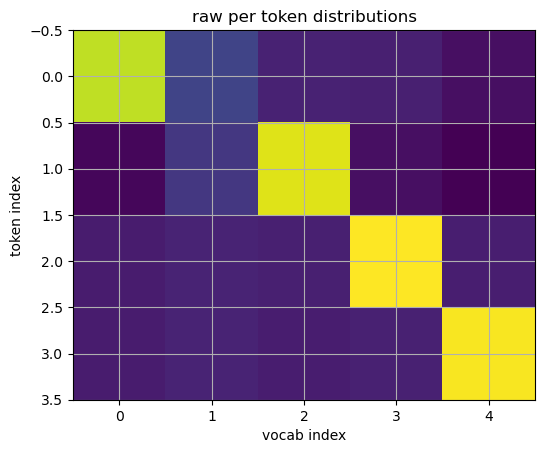

In [ ]:
# PLOT THE PER-TOKEN OUTPUT DISTRIBUTIONS OVER THE VOCABULARY
x = ['bos',3,1,5,4]
raw_dists = copy.deepcopy(assembled_model.apply(x).raw_token_dists[0,1:,:]) #B,T,V
fig, ax = plt.subplots()
ax.imshow(raw_dists)
ax.set(xlabel='vocab index',ylabel='token index',title='raw per token distributions')
ax.grid()
plt.show()

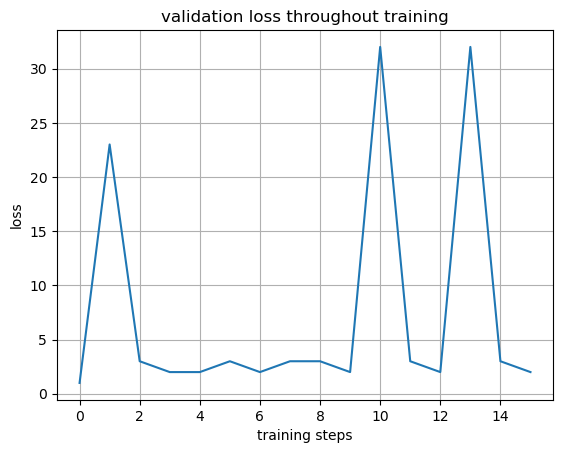

[Array(6.8237343, dtype=float32)]
[Array(6.8237343, dtype=float32), Array(1.2800565, dtype=float32)]
[Array(6.8237343, dtype=float32), Array(1.2800565, dtype=float32), Array(1.070029, dtype=float32)]
[Array(6.8237343, dtype=float32), Array(1.2800565, dtype=float32), Array(1.070029, dtype=float32), Array(1.0269785, dtype=float32)]


KeyboardInterrupt: 

In [ ]:
# OK, we now have ahold of transformer outputs that we can interpret as logits for each token; can we train them?
initial_params = copy.deepcopy(assembled_model.params)
# f = hk.without_apply_rng(hk.transform(assembled_model.apply))
# fn = assembled_model.apply

# def testing(params):
#     assembled_model = compiling.compile_rasp_to_model(
#       program=program,
#       vocab=vocab,
#       max_seq_len=max_seq_len,
#       causal=False,# aha
#       compiler_bos="bos",
#       compiler_pad="pad",
#       mlp_exactness=100)
#     f = hk.without_apply_rng(hk.transform(assembled_model.apply))
#     return f.apply(params, 0)

def oliver_testing(x):
    assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=SORT_MAX,
      causal=False,# aha
      compiler_bos="bos",
      compiler_pad="pad",
      mlp_exactness=100)
    return assembled_model.apply(x)

# f = hk.without_apply_rng(hk.transform(oliver_testing))
# f = hk.without_apply_rng(hk.transform(assembled_model.forward))
f = assembled_model.functional_apply

# B=1 for now... (did I cause that or was it already like that?)
def loss_fn(params, x, y):
    # Standard softmax cross entropy loss.
    # return params['transformer/layer_0/attn/query']['b'][0] #testing!!!!
    # a = f.apply(params,x)
    # return a[0,0,0]# can we even get a gradient through the returned raw logit things????
    # return a.params['transformer/layer_0/attn/query']['b'][0]# can we even get a gradient through the returned chex data structure???
    # print(type(a))
    logits = f(params,x).raw_token_dists               # get logits form forward pass of model
    #print(params)
    
    #benjie:
    # logits = f.apply(params, 0) #f.apply(params,{'pos_embed': {'embeddings': jnp.zeros_like(params['pos_embed']['embeddings'])}})
    # return logits["mystuff"]

    logits = logits[0,1:,:] # has shape [T-1, V] where T is sequence lenght and V is vocab size (T-1 because we don't train for the bos token)
    # print('logits',logits.round(2))
    # print(logits.shape)
    y_indices = assembled_model.input_encoder.encode(y)[1:]          # maps the ground truth y output tokens to their vocab indices (skips the bos token)
    # print('HAHAHAH',len(y_indices))
    y = jax.nn.one_hot(y_indices, logits.shape[-1])                 # get the one-hot encoding of the ground truth indices
    # print('y',y)
    # # print(y.shape)
    # print('cross entropy loss',-jnp.sum(y * jax.nn.log_softmax(logits),axis=1))
    ultimate_loss = -jnp.sum(y * jax.nn.log_softmax(logits)) / y.shape[0]
    # print(ultimate_loss)
    return ultimate_loss    # compute and return the (average) cross entropy loss

optimizer = optax.sgd(learning_rate=1e-3)
opt_state = optimizer.init(initial_params)
params = initial_params

def train_step(params, opt_state, x, y):
    # print(loss_fn(params,x,y))
    grads = jax.grad(loss_fn)(params, x, y)
    # print("gradients",grads)
    # print(grads[0,0,0])
    # print('specific gradient for testin',grads['transformer/layer_0/attn/query']['b'][0])
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

# train_step = jax.jit(train_step) # for this to work we would need to make the forward pass only deal with numbers not strings....
val_losses = []
# par = copy.deepcopy(assembled_model.params)
# dummy_x = train_x[0]
# params = f.init(None,dummy_x)
# print(params)

# figure, ax = plt.subplots(figsize=(10, 8))
# line1, = ax.plot(x, y)
# val_loss_curve.set_ydata(val_losses)
# fig, ax = plt.subplots()
# val_loss_curve, = ax.plot([1,23,3,2,2,3,2,3,3,2,32,3,2,32,3,2])
# ax.set(xlabel='training steps',ylabel='loss',title='validation loss throughout training')
# ax.grid()
# plt.ion()
# plt.show() 

for i, (x, y) in enumerate(zip(train_x,train_y)):
    # print("x,y",x,y)
    params, opt_state = train_step(params, opt_state, x, y)
    if i % 100 == 0:
        # compute average loss on the "validation" set
        loss = 0
        for (x,y) in zip(val_x,val_y):
            loss += loss_fn(params, x, y)
        loss /= len(val_x)
        val_losses.append(loss)
        # val_loss_curve.set_xdata(range(len(val_losses)))#[i for i in range(len(val_losses))], [i for i in range(len(val_losses))])#val_losses)    # Update plot
        # val_loss_curve.set_ydata(val_losses)
        # fig.canvas.draw()
        # fig.canvas.flush_events()
        # print('here')
        # print(val_losses)
        print(loss)
        # plt.pause(1)

In [ ]:
# GARBAGE OLD CODE
# // ASSORTED DEBUGGING CODE
# print('So we have a compiled model for sorting:',assembled_model.model_config)
# print('x',x)
# print('out.decoded',out.decoded)
# # print('out.transformer_output.shape',out.transformer_output.shape)
# # print('out.unembedded[0]',out.unembedded[0])
# # print('out.attn_logits[-1].shape',out.attn_logits[-1].shape)
# # print('len(out.residuals)',len(out.residuals))
# # print('len(out.layer_outputs)',len(out.layer_outputs))
# # print('out.layer_outputs[-1].shape',out.layer_outputs[-1].shape)
# print('Among the many things in `out` we now have the following raw_token_dists...')
# print('out.raw_token_dists.shape',out.raw_token_dists.shape)
# print('out.raw_token_dists',out.raw_token_dists)
# print('Sanity check: can we decode from them manually?')
# raw_dists = out.raw_token_dists[0,:,:]
# # print(raw_dists.shape)
# argmaxed_dists = np.argmax(raw_dists,axis=1)
# print(argmaxed_dists)
# print([assembled_model.input_encoder.bos_token] + assembled_model.output_encoder.decode(argmaxed_dists.tolist())[1:])
# assembled_model.params['transformer/layer_0/attn/query']['b'][0]
# out = f.apply(initial_params,None,['bos',3,1,2])
# out.raw_token_dists.shape
# x,y = ['bos',3,1],['bos',1,3]
# params = train_step(params, opt_state, x, y)
# x, y = dataset_x[0], dataset_y[0]
# x,y = ['bos',3,1],['bos',1,3]
# print(x,y)
# loss_fn(initial_params,x,y)
# # What if we look at out.transformer_output?
# outs = out.transformer_output[0,:,:]
# print('out.transformer_output.shape',out.transformer_output.shape)
# embeddings = assembled_model.params['token_embed']['embeddings'].transpose()
# print('assembled_model.params.keys()',assembled_model.params.keys())
# print('outs.shape',outs.shape)
# print('tok_embeddings.shape',embeddings.shape)
# # pos_embeddings = assembled_model.params['pos_embed']['embeddings'].transpose()
# # print('pos_embeddings.shape',pos_embeddings.shape)
# distsmaybe = outs @ embeddings
# # pos_something = outs @ pos_embeddings
# print('distsmaybe',distsmaybe)
# # print('pos_something',pos_something)
# print('input x:',x)
# print('pretend output (undecoded):',np.argmax(distsmaybe,axis=1))
# print('pretend output (decoded):',assembled_model.input_encoder.decode(np.argmax(distsmaybe,axis=1)))

# model_config, module_names = _get_model_config_and_module_names(craft_model)
# model_config.causal = causal
# residual_space = bases.join_vector_spaces(craft_model.residual_space, tokens_space, indices_space, output_space)
# res_to_out = vectorspace_fns.project(residual_space, output_space)
# print(type(assembled_model.get_compiled_model()))# no need for that
# let's just try argmaxing this thing
# maybe it's actually logit like
# def unembed(x):
#     out = x @ res_to_out.matrix
#     return jnp.argmax(out, axis=-1)
# out.unembedded
# def compute_loss_and_updates(trainable_variables, non_trainable_variables, x, y):
#     y_pred, non_trainable_variables = model.stateless_call(
#         trainable_variables, non_trainable_variables, x
#     )
#     loss = loss_fn(y, y_pred)
#     return loss, non_trainable_variables

# grad_fn = jax.value_and_grad(compute_loss_and_updates, has_aux=True)
# (loss, non_trainable_variables), grads = grad_fn(
#     trainable_variables, non_trainable_variables, x, y
# )

# def train_step(state, data):
#     trainable_variables, non_trainable_variables, optimizer_variables = state
#     x, y = data
#     (loss, non_trainable_variables), grads = grad_fn(
#         trainable_variables, non_trainable_variables, x, y
#     )
#     trainable_variables, optimizer_variables = optimizer.stateless_apply(
#         grads, trainable_variables, optimizer_variables
#     )
#     # Return updated state
#     return loss, (
#         trainable_variables,
#         non_trainable_variables,
#         optimizer_variables,
#     )
# Train the compiled model
# num_epochs = 10
# batch_size = 100
# for epoch in range(num_epochs):
#     for batch_num in range(math.floor(len(dataset_x) / batch_size)):
#         idx = batch_num * batch_size
#         x_batch, y_batch = dataset_x[idx:idx+batch_size], dataset_y[idx:idx+batch_size]
#         for x in x_batch:
#             y_pred = assembled_model.apply(x)
#             print(y_pred.decoded)
#             # print(len(y_pred.layer_outputs))
#             # print(y_pred.layer_outputs[1])
#             print(y_pred.transformer_output[1])
#             break
#         break
#     break

In [ ]:
# PLOTTING FUNCTIONS FROM THE ORIGINAL VERSION OF THIS NOTEBOOK

#@title Plotting functions
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)
  
#@title Plot residual stream
plot_residuals_and_input(
  model=assembled_model,
  inputs=["bos", 3, 4, 1],
  figsize=(10, 9)
)
#@title Plot residual stream
plot_residuals_and_input(
  model=assembled_model,
  inputs=["bos", 3, 4, 1],
  figsize=(10, 9)
)
#@title Plot layer outputs
plot_layer_outputs(
  model=assembled_model,
  inputs = ["bos", 3, 4, 1],
  figsize=(8, 9)
)